### Segunda versión

Tal y como se indica en el archivo 'ML_v1.ipynb', en esta segunda versión del modelo elimaremos todas las variables relacionadas con el partido. Es decir, no solo el 'score' sino también todos los atributos relacionados con el rendimiento de los jugadores durante el partido, ya que realmente son datos que el modelo no tendría a su disposición ante del partido. 

El objetivo es comparar si hay mucho cambio en el rendimiento de los modelos cuando eliminados estos atributos.

In [1]:
import pandas as pd
import numpy as np
from random import seed
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, mean_squared_error as mse
from joblib import dump,load

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('/Users/juliacorominasfont/Desktop/DS BOOTCAMP/Projecte Final/ML/clean_data.csv')
df.head(5)

,Unnamed: 0,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,...,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,loser_rank,year
0,0,1991-339,Adelaide,Hard,32,A,1990-12-31,1,101723,Magnus Larsson,...,95.0,62.0,44.0,23.0,16.0,6.0,8.0,56.0,2.0,1990
1,1,1991-339,Adelaide,Hard,32,A,1990-12-31,2,100946,Slobodan Zivojinovic,...,84.0,41.0,35.0,27.0,15.0,1.0,2.0,304.0,75.0,1990
2,2,1991-339,Adelaide,Hard,32,A,1990-12-31,3,101234,Patrik Kuhnen,...,60.0,37.0,22.0,6.0,8.0,4.0,8.0,82.0,69.0,1990
3,3,1991-339,Adelaide,Hard,32,A,1990-12-31,4,101889,Todd Woodbridge,...,74.0,45.0,30.0,11.0,10.0,5.0,8.0,50.0,84.0,1990
4,4,1991-339,Adelaide,Hard,32,A,1990-12-31,5,101274,Udo Riglewski,...,77.0,41.0,28.0,15.0,11.0,4.0,8.0,88.0,28.0,1990


Primero, eliminamos la variable 'score' y también los atributos relacionados con el rendimiento de los jugadores durante el partido.

In [4]:
df.drop(['Unnamed: 0', 'score', 'w_ace', 'w_df',
       'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved',
       'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon',
       'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced'], axis=1, inplace=True)

Asimismo, vemos que la tabla identifica a los jugadores como Winner y Loser, por lo que para el modelo sería muy obvio quien gana el partido. Es por esto que aleatoriamente asignaremos el número 1 o 2 a todos los jugadores, creando un label que sea 1, cuando el jugador 1 gane el partido, y 0 cuando gane el jugador 2.

In [5]:
from random import seed
from random import randint

def assign_players(row):
    random_number = randint(1, 2)
    if random_number == 1:
        return (
            row['winner_id'], row['winner_name'], row['winner_hand'], row['winner_ht'], row['winner_ioc'], row['winner_age'], row['winner_rank'],
            row['loser_id'], row['loser_name'], row['loser_hand'], row['loser_ht'], row['loser_ioc'], row['loser_age'], row['loser_rank']
        )
    else:
        return (
            row['loser_id'], row['loser_name'], row['loser_hand'], row['loser_ht'], row['loser_ioc'], row['loser_age'], row['loser_rank'],
            row['winner_id'], row['winner_name'], row['winner_hand'], row['winner_ht'], row['winner_ioc'], row['winner_age'], row['winner_rank']
        )

def create_player_columns(df):
    df[['Player1_id', 'Player1_name', 'Player1_hand', 'Player1_ht', 'Player1_ioc', 'Player1_age', 'Player1_rank',
        'Player2_id', 'Player2_name', 'Player2_hand', 'Player2_ht', 'Player2_ioc', 'Player2_age', 'Player2_rank']] = df.apply(assign_players, axis=1, result_type='expand')
    return df

def create_label(df):
    return 1 if df['winner_id'] == df['Player1_id'] else 0

def df_preprocessing(df):
    df = create_player_columns(df)
    df['label'] = df.apply(create_label, axis=1)
    df.drop(columns=['winner_id', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'winner_rank', 'loser_rank'],
            inplace=True)
    return df

df = df_preprocessing(df)
df.head(5)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,loser_id,loser_name,loser_hand,...,Player1_age,Player1_rank,Player2_id,Player2_name,Player2_hand,Player2_ht,Player2_ioc,Player2_age,Player2_rank,label
0,1991-339,Adelaide,Hard,32,A,1990-12-31,1,101414,Boris Becker,R,...,23.1,2.0,101723,Magnus Larsson,R,193.0,SWE,20.7,56.0,0
1,1991-339,Adelaide,Hard,32,A,1990-12-31,2,101256,Mark Kratzmann,L,...,27.4,304.0,101256,Mark Kratzmann,L,178.0,AUS,24.6,75.0,1
2,1991-339,Adelaide,Hard,32,A,1990-12-31,3,101421,Veli Paloheimo,R,...,24.8,82.0,101421,Veli Paloheimo,R,183.0,FIN,23.0,69.0,1
3,1991-339,Adelaide,Hard,32,A,1990-12-31,4,101703,Guillaume Raoux,R,...,20.8,84.0,101889,Todd Woodbridge,R,178.0,AUS,19.7,50.0,0
4,1991-339,Adelaide,Hard,32,A,1990-12-31,5,101843,Sergi Bruguera,R,...,24.4,88.0,101843,Sergi Bruguera,R,188.0,ESP,19.9,28.0,1


Estudiamos la correlación entre las variables y con el label.

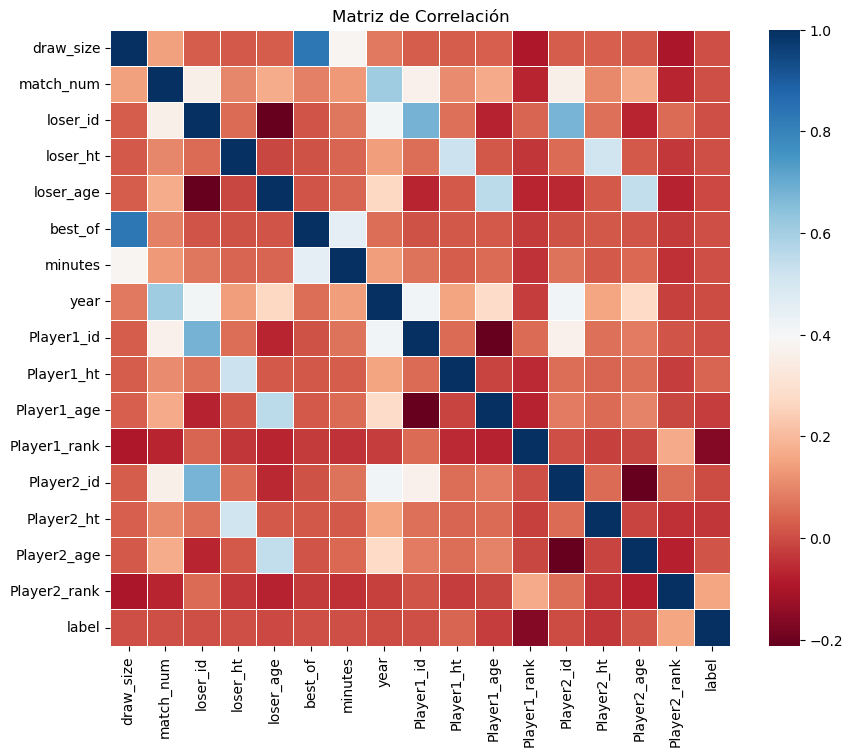

In [6]:
plt.figure(figsize=(10, 8))  # Ajusta el tamaño del gráfico según tus preferencias
sns.heatmap(df.corr(), cmap="RdBu", fmt=".2f", linewidths=.5)
plt.title("Matriz de Correlación")
plt.show()

In [7]:
df.corr()['label'].sort_values()

Player1_rank   -0.162300
Player2_ht     -0.040118
Player1_age    -0.023428
loser_age      -0.003807
Player2_id      0.000415
year            0.000431
draw_size       0.001275
minutes         0.001460
loser_id        0.002417
loser_ht        0.002730
best_of         0.003138
match_num       0.003579
Player1_id      0.004843
Player2_age     0.014910
Player1_ht      0.042476
Player2_rank    0.156447
label           1.000000
Name: label, dtype: float64

Vemos que los atributos con mayor correlación con el 'label' son aquellos relacionados con el ranking de los jugadores, seguidos de la altura y la edad. Sin embargo, en general las correlaciones son muy bajas.

In [8]:
df.shape

(94344, 32)

In [9]:
df.duplicated().sum()

0

In [10]:
df['label'].unique()

array([0, 1])

In [11]:
dump(df, 'datos_v2.df')

['datos_v2.df']

### EDA de los datos para entrenar el modelo

<Figure size 800x500 with 0 Axes>

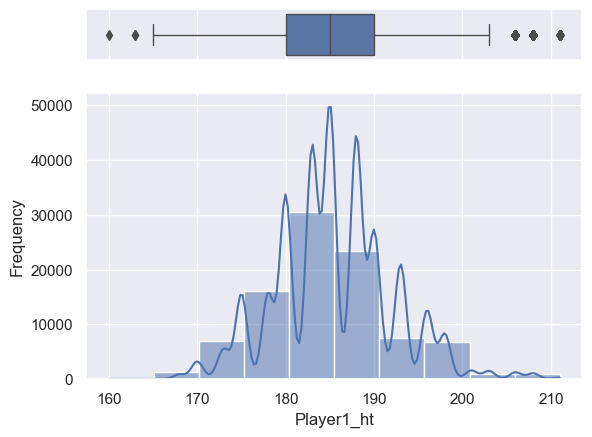

<Figure size 800x500 with 0 Axes>

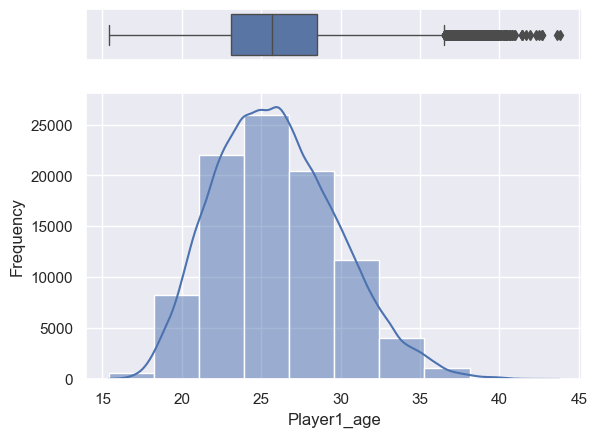

<Figure size 800x500 with 0 Axes>

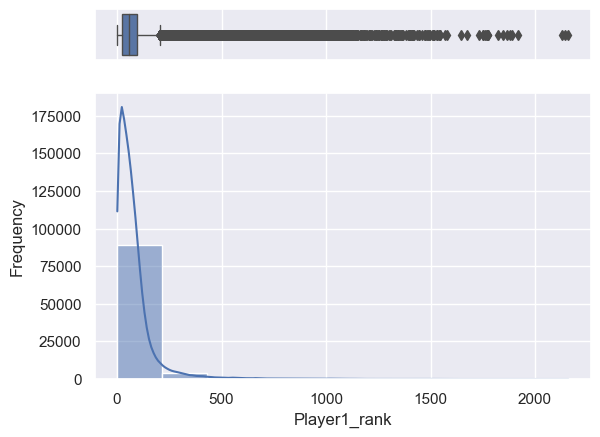

<Figure size 800x500 with 0 Axes>

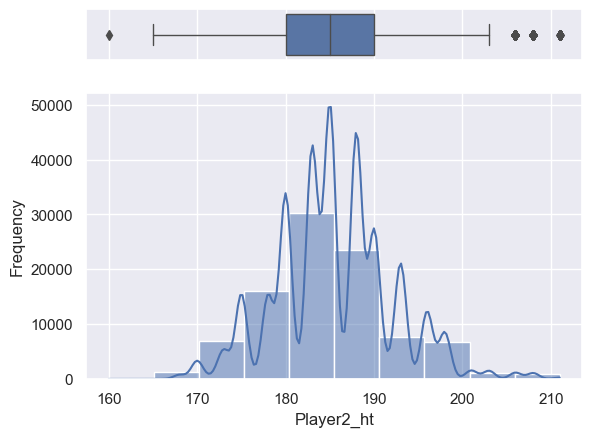

<Figure size 800x500 with 0 Axes>

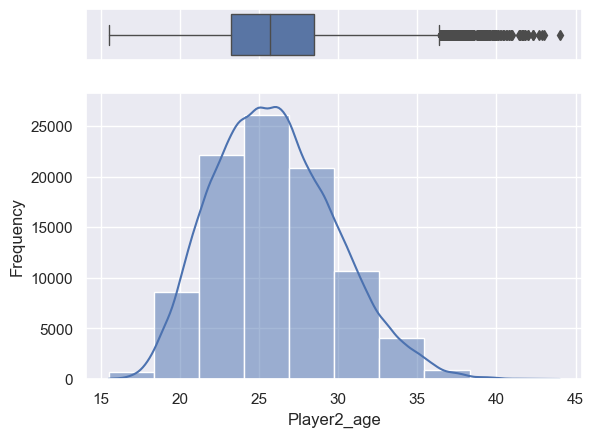

<Figure size 800x500 with 0 Axes>

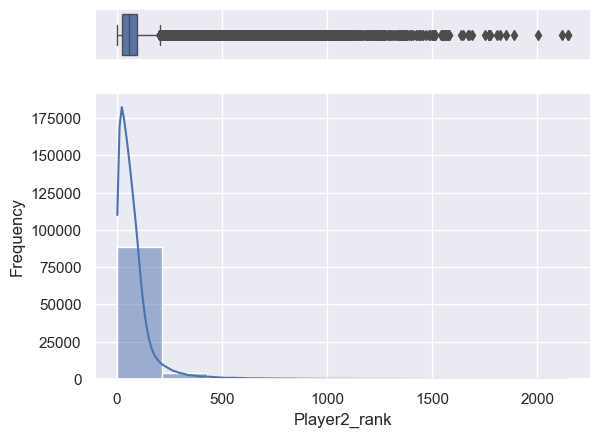

In [12]:
numerical_features = ['Player1_ht', 'Player1_age', 'Player1_rank', 'Player2_ht', 'Player2_age', 'Player2_rank']

for i in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.set()
    
    filtered_data = df[df[i].notna()]
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    sns.boxplot(x=df[i], orient="h", ax=ax_box, linewidth=1.0)
    
    # Dibuja el histograma en la parte inferior
    sns.histplot(df[i], ax=ax_hist, bins=10, kde=True)
    
    ax_box.set(xlabel='')
    ax_hist.set(xlabel=i)
    
    plt.gca().set(xlabel= i,ylabel='Frequency')

Vemos que las variables 'Player1_ht' y 'Player2_ht' tienen una distribución normal, y el resto no son normales y tienen outliers. Por tanto, aplicaremos StandardScaler() a las primeras y el RobustScaler() a las segundas.

### Transformaciones

#### Variables numéricas

Hemos visto que ninguna tiene una distribución normal y que todas tienen outliers.

In [13]:
numeric_features = ['Player1_ht', 'Player2_ht']
numeric_transformer = Pipeline(
    steps=[
        ('imputer_num', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

numeric_features_out = ['Player1_age', 'Player1_rank', 'Player2_age', 'Player2_rank']
numeric_transformer_out = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy = 'median')),
        ('robust', RobustScaler())
    ]
)

#### Variables categóricas

Aplicaremos la técnica OneHotEncoding a todas las variables ya que tienen más de dos valores.

In [14]:
categorical_features = ['surface', 'tourney_level', 'round', 'Player1_hand', 'Player2_hand']
categorical_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'most_frequent')),
        ('onehot', OneHotEncoder(sparse=False))
    ]
)

#### Pipeline

Aplicamos las transformaciones anteriores al conjunto de datos con el ColumnTransformer(). Este Pipeline es el que aplicaremos cuando hagamos los modelos.

In [15]:
preprocessor = ColumnTransformer(
    [
        ('categoricals', categorical_transformer, categorical_features),
        ('numericals', numeric_transformer, numeric_features),
        ('numericals_out', numeric_transformer_out, numeric_features_out) 
    ],
    remainder = 'drop'
)

In [16]:
preprocessor

ColumnTransformer(transformers=[('categoricals',
                                 Pipeline(steps=[('imputer_cat',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(sparse=False))]),
                                 ['surface', 'tourney_level', 'round',
                                  'Player1_hand', 'Player2_hand']),
                                ('numericals',
                                 Pipeline(steps=[('imputer_num',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Player1_ht', 'Player2_ht']),
                                ('numericals_out',
                                 Pipeline(steps=[('imputer_num',
                                                  SimpleImputer(strategy='median')),
                                                 ('robust', RobustScaler())]),
                                 ['Player1_age', 'Player1_rank', 'Player2_age',
                                  'Player2_rank'])])

### Train y Test

In [17]:
df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,loser_id,loser_name,loser_hand,...,Player1_age,Player1_rank,Player2_id,Player2_name,Player2_hand,Player2_ht,Player2_ioc,Player2_age,Player2_rank,label
0,1991-339,Adelaide,Hard,32,A,1990-12-31,1,101414,Boris Becker,R,...,23.1,2.0,101723,Magnus Larsson,R,193.0,SWE,20.7,56.0,0
1,1991-339,Adelaide,Hard,32,A,1990-12-31,2,101256,Mark Kratzmann,L,...,27.4,304.0,101256,Mark Kratzmann,L,178.0,AUS,24.6,75.0,1
2,1991-339,Adelaide,Hard,32,A,1990-12-31,3,101421,Veli Paloheimo,R,...,24.8,82.0,101421,Veli Paloheimo,R,183.0,FIN,23.0,69.0,1
3,1991-339,Adelaide,Hard,32,A,1990-12-31,4,101703,Guillaume Raoux,R,...,20.8,84.0,101889,Todd Woodbridge,R,178.0,AUS,19.7,50.0,0
4,1991-339,Adelaide,Hard,32,A,1990-12-31,5,101843,Sergi Bruguera,R,...,24.4,88.0,101843,Sergi Bruguera,R,188.0,ESP,19.9,28.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94339,2023-0605,Tour Finals,Hard,8,A,2023-11-13,290,126094,Andrey Rublev,R,...,26.0,5.0,207989,Carlos Alcaraz,R,185.0,ESP,20.5,2.0,0
94340,2023-0605,Tour Finals,Hard,8,A,2023-11-13,289,207989,Carlos Alcaraz,R,...,26.5,7.0,207989,Carlos Alcaraz,R,185.0,ESP,20.5,2.0,1
94341,2023-0605,Tour Finals,Hard,8,A,2023-11-13,288,126094,Andrey Rublev,R,...,27.7,3.0,126094,Andrey Rublev,R,188.0,RUS,26.0,5.0,1
94342,2023-0605,Tour Finals,Hard,8,A,2023-11-13,287,100644,Alexander Zverev,R,...,26.5,7.0,106421,Daniil Medvedev,R,198.0,RUS,27.7,3.0,0


In [18]:
X = df.drop('label', axis=1)
y = df['label']

In [19]:
y.value_counts()

0    47386
1    46958
Name: label, dtype: int64

El 'label' está balanceado, no requiere de técnicas de balanceo. 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X_train

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,loser_id,loser_name,loser_hand,...,Player1_ioc,Player1_age,Player1_rank,Player2_id,Player2_name,Player2_hand,Player2_ht,Player2_ioc,Player2_age,Player2_rank
8875,1993-423,Los Angeles,Hard,32,A,1993-08-02,11,108429,Tony Bujan,R,...,USA,22.8,567.0,101543,Jeff Tarango,L,180.0,USA,24.6,70.0
20017,1997-339,Adelaide,Hard,32,A,1996-12-30,2,102202,Kenneth Carlsen,L,...,ZIM,27.2,44.0,102202,Kenneth Carlsen,L,190.0,DEN,23.7,73.0
34590,2001-560,US Open,Hard,128,G,2001-08-27,10,103181,Jiri Vanek,R,...,CZE,23.3,94.0,101733,Jan Siemerink,L,183.0,NED,31.3,96.0
75413,2016-0315,Newport,Grass,32,A,2016-07-11,293,105216,Yuichi Sugita,R,...,USA,26.5,25.0,105216,Yuichi Sugita,R,173.0,JPN,27.8,107.0
29454,2000-314,Gstaad,Clay,32,A,2000-07-10,28,103206,Sebastien Grosjean,R,...,FRA,22.1,27.0,103264,Mariano Puerta,L,180.0,ARG,21.8,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,1992-457,Taipei,Carpet,32,A,1992-10-19,21,101364,Bret Garnett,R,...,ITA,22.5,96.0,101364,Bret Garnett,R,185.0,USA,25.3,365.0
54886,2008-747,Beijing,Hard,28,A,2008-09-22,19,104269,Fernando Verdasco,L,...,ESP,24.8,15.0,103507,Juan Carlos Ferrero,R,183.0,ESP,28.6,48.0
76820,2017-M-DC-2017-WG-M-BEL-GER-01,Davis Cup WG R1: BEL vs GER,Hard,4,D,2017-02-03,2,105963,Arthur De Greef,R,...,GER,19.7,22.0,105963,Arthur De Greef,R,183.0,BEL,24.8,143.0
860,1991-425,Barcelona,Clay,56,A,1991-04-08,32,100653,Andres Gomez,L,...,URU,23.6,53.0,100653,Andres Gomez,L,193.0,ECU,31.1,11.0


In [22]:
rfc = RandomForestClassifier(random_state = 42)

pipeline = Pipeline([
            ('preprocessing', preprocessor),
            ('model', rfc)
        ])

In [23]:
pipeline.fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(pipeline.score(X_test, y_test)))

R2 score: 0.64


En comparación con la primera versión, el rendimiento del modelo ha empeorado, pasando de 0,9 a 0,64. Tiene sentido teniendo en cuenta que los atributos sobre el rendimiento del jugador durante el partido dan mucha información sobre el juego, aunque no determinen quien ha ganado.

In [24]:
pipeline.predict(X_test)

array([0, 1, 1, ..., 1, 0, 0])

In [25]:
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categoricals',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['surface', 'tourney_level',
                                                   'round', 'Player1_hand',
                                                   'Player2_hand']),
                                                 ('numericals',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Player1_ht', 'Player2_ht']),
                                                 ('numericals_out',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  ['Player1_age',
                                                   'Player1_rank',
                                                   'Player2_age',
                                                   'Player2_rank'])])),
                ('model', RandomForestClassifier(random_state=42))])

Miramos otros modelos:

In [26]:
lda = LinearDiscriminantAnalysis()
knc = KNeighborsClassifier()
gnb = GaussianNB()
dtc = DecisionTreeClassifier(random_state = 42)
svc = SVC(random_state = 42)
rfc = RandomForestClassifier(random_state = 42)
lr = LogisticRegression(random_state=42)

In [27]:
modelos = {
    'lda': lda,
    'knc': knc,
    'gnb' : gnb,
    'dtc' : dtc,
    'svc' : svc,
    'rfc' : rfc,
    'lr' : lr
}

In [28]:
data_y = {}
metrics = []

for name, model in modelos.items():
    pipeline = Pipeline([
            ('preprocessing', preprocessor),
            ('model', model)
        ])
    pipeline.fit(X_train, y_train)
     
    data_y[name] = pipeline.predict(X_test)

    metrics.append({
        'Modelo': name,
        'Score': pipeline.score(X_test, y_test)
    })

df_y = pd.DataFrame(data_y)
df_metrics = pd.DataFrame(metrics)

In [29]:
df_y['y_test'] = y_test.reset_index(drop=True)

In [30]:
df_y

,lda,knc,gnb,dtc,svc,rfc,lr,y_test
0,0,0,0,0,0,0,0,0
1,1,1,0,0,1,1,1,0
2,1,1,1,1,1,1,1,0
3,1,1,0,1,1,1,1,1
4,1,1,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...
18864,0,0,0,0,0,0,0,1
18865,0,0,0,0,0,0,0,1
18866,0,1,0,1,1,1,1,1
18867,0,0,0,0,0,0,0,0


In [31]:
df_metrics

,Modelo,Score
0,lda,0.627855
1,knc,0.585829
2,gnb,0.534104
3,dtc,0.568764
4,svc,0.651863
5,rfc,0.638084
6,lr,0.636706


In [32]:
dump(df_metrics, 'df_metrics_v2.df')

['df_metrics_v2.df']

Text(0, 0.5, 'Densidad')

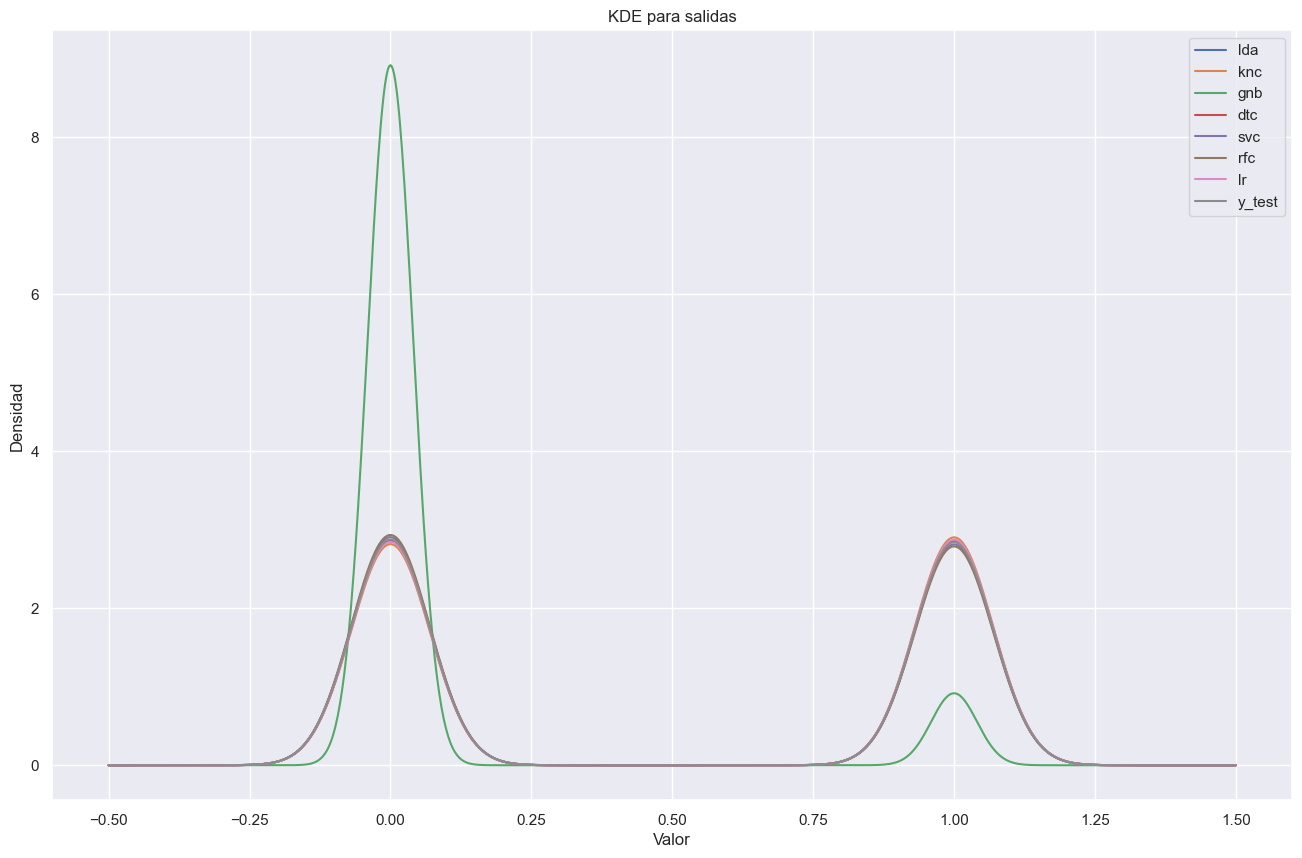

In [33]:
fig, ax = plt.subplots(figsize=(16, 10))
df_y.plot.kde(ax=ax)
plt.title('KDE para salidas')
plt.xlabel('Valor')
plt.ylabel('Densidad')

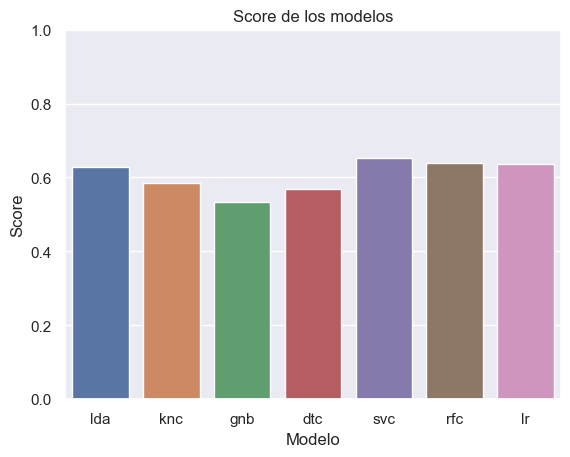

In [34]:
sns.barplot(data=df_metrics, x = 'Modelo', y = 'Score')
plt.title('Score de los modelos')
plt.ylim(0, 1);

### Evaluación de los modelos

In [35]:
evaluation = pd.DataFrame({'model':['lda','knc','gnb','dtc','svc','rfc','lr']})

In [36]:
from sklearn.model_selection import cross_val_score

models = [lda, knc, gnb, dtc, svc, rfc, lr]
score_mean = []
score_std = []

for model in models:
    pipeline = Pipeline(
        [
            ('preprocessing', preprocessor),
            ('model', model)
        ]
    )
    X_array = X.values if isinstance(X, pd.DataFrame) else X

    score = cross_val_score(pipeline, X, y, cv=5, scoring='f1')
    print(score)
    score_mean.append(np.nanmean(score)) 
    score_std.append(np.nanstd(score))

[0.63585106 0.62265558        nan 0.62468186        nan]
[0.57573168 0.57780381        nan 0.57730633        nan]
[0.42463689 0.25197935        nan 0.21666815        nan]
[0.55784724 0.55641422        nan 0.56447844        nan]
[0.64126814 0.63010314        nan 0.66727282        nan]
[0.62156905 0.61407203        nan 0.64363439        nan]
[0.6394471  0.63201487        nan 0.64097998        nan]


In [37]:
evaluation['f1_cv'] = score_mean
evaluation['f1_std_cv'] = score_std
evaluation

,model,f1_cv,f1_std_cv
0,lda,0.627730,0.005802
1,knc,0.576947,0.000883
2,gnb,0.297761,0.090865
3,dtc,0.559580,0.003513
4,svc,0.646215,0.015572
5,rfc,0.626425,0.012548
6,lr,0.637481,0.003915


Seleccionamos el mejor modelo y buscamos sus mejores hiperparámetros:

In [38]:
pipeline_SVC = Pipeline([
    ('preprocessing', preprocessor),
    ('pca', PCA(0.99)),
    ('model', SVC())
])

params_SVC = {
    'model__kernel': ['linear', 'poly', 'sigmoid'],
    'model__random_state': [42]
}

gs_SVC = GridSearchCV(pipeline_SVC, params_SVC, cv=5, scoring='accuracy', refit='accuracy', n_jobs=-1)

gs_SVC.fit(X, y)

best_model_SVC = gs_SVC.best_estimator_

print(f'Best parameter set: {gs_SVC.best_params_}\n')
print(f'Scores: {classification_report(y, gs_SVC.predict(X))}')

/Users/juliacorominasfont/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliacorominasfont/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliacorominasfont/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliacorominasfont/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarn

Best parameter set: {'model__kernel': 'linear', 'model__random_state': 42}

Scores:               precision    recall  f1-score   support

           0       0.64      0.64      0.64     47386
           1       0.63      0.63      0.63     46958

    accuracy                           0.64     94344
   macro avg       0.64      0.64      0.64     94344
weighted avg       0.64      0.64      0.64     94344



Hacemos una matriz de confusión del mejor modelo:

Accuracy score: 0.63


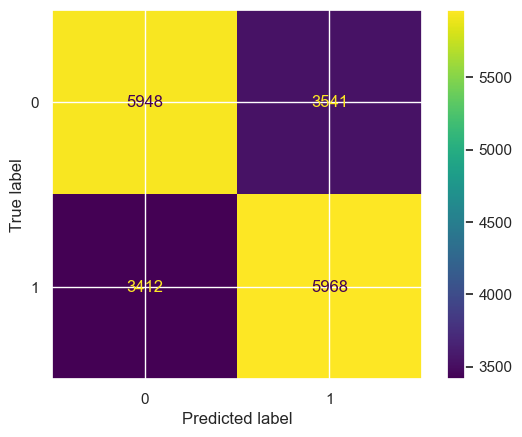

In [39]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model_SVC.fit(X_train, y_train)
print('Accuracy score: {0:.2f}'.format(best_model_SVC.score(X_test, y_test)))

y_pred = best_model_SVC.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [40]:
df_y['y_pred_best'] = y_pred

In [41]:
dump(df_y, 'df_y.df')

['df_y.df']

### Predicciones

In [42]:
X_new = pd.DataFrame([['1991-339', 'Adelaide', 'Hard', 32, 'A', '1990-12-31', 1, 3, 'R32', 130.0, 1990, 101723, 'Magnus Larsson', 'R', 193.0, 'SWE', 20.7, 56.0, 101414, 'Boris Becker', 'R', 190.0, 'GER', 23.1, 2.0]],
                     columns= [['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'best_of', 'round', 'minutes', 'year',
       'Player1_id', 'Player1_name', 'Player1_hand', 'Player1_ht',
       'Player1_ioc', 'Player1_age', 'Player1_rank',
       'Player2_id', 'Player2_name', 'Player2_hand', 'Player2_ht',
       'Player2_ioc', 'Player2_age', 'Player2_rank']])

y_new = best_model_SVC.predict(X_new)
y_new

array([0])

In [44]:
dump(best_model_SVC, 'best_model_v2.joblib')

['best_model_v2.joblib']